# Demonstration of a GAP Range Map Evaluation Framework
This notebook details a framework for evaluating GAP range maps with occurrence data retrieved from databases such as GBIF via APIs.  It details the major steps and features of the framework for a single species: the yellow-billed cuckoo.  The primary results are some maps for visualization, columns added to a GAP range data .csv file that is downloaded from ScienceBase, and documentation of decisions and archiving of data used. 

See the README.md file in this repository for more information.

There are a few major steps.  

### 1. Range Evaluation Parameter Database
This process requires some decision making about how to filter the records and other things.  Such decisions are documented in a database that can be queried in the other steps and referred to later for reference.

### 2. Species Concepts
Taxonomic classifications are periodically revised,  creating the potential for disagreement among organizations/efforts/databases about what a species name actually refers to.  That disagreement needs to be assessed and resolved before retrievals of occurrence records can be fully trusted.

### 3. Retrieve and Filter Species Occurrence Records
Occurrence records can be accessed through API's, filtered, and saved in a database.  Filtering can happen during the request for records or after they have been received, but occur before the records are stored in a local database in this framework.  The precision of occurrence records varies due to coordinate uncertainty and detection distances, so points must be represented as circles (i.e., buffered)

### 4. Evaluate GAP Known Range Data
GAP ranges exist in table form in a database and on ScienceBase.  Ranges can be compared to occurrence circles to find HUCs where GAP was correct about species' presence and where it was wrong about absence.  The results of those comparisons can be saved in columns in the range tables.

### BONUS -- Automated range delineation
The occurrence record database populated for range evaluation could also be a source for range delineation: either by an expert or with an automated process.  Spatialite has a concave hull function that can be deployed.  I generated seasonal, yearly, and monthly range maps with that process, but they were of poor quality. 

### General Setup
Some parameters need to be declared, including a unique name for this evaluation.  

In [2]:
%matplotlib inline
import sqlite3
import pprint
import pandas as pd
#import geopandas as gpd
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 60)
from IPython.display import Image

gap_id = 'bybcux'
inDir = '/users/nmtarr/documents/ranges/inputs/'
outDir = '/users/nmtarr/documents/ranges/outputs/'
summary_name = 'cuckoo' # an short, memorable name to use for file names etc.
years = '1990-2015'
eval_id = 'eval_gbif1'

## 1. Range Evaluation Parameter Database

Descriptions of all the columns in the databse are listed below.  As more filtering parameters are explored and employed for each data source, they would need to be described.  

In [3]:
conn = sqlite3.connect('/users/nmtarr/documents/ranges/inputs/rng_eval_params.sqlite')
cursor = conn.cursor()
table_names = cursor.execute("SELECT DISTINCT table_name FROM column_descriptions;").fetchall()
for table in table_names:
    table = table[0]
    print("\n\n" + table.upper() + " TABLE\n")
    print(" Id, Column Name, Data Type, Not Null, Default, Unique")
    pprint.pprint(cursor.execute("PRAGMA table_info('{0}');".format(table)).fetchall())
    df = cursor.execute("SELECT * FROM column_descriptions WHERE table_name='{0}'".format(table)).fetchall()
    for row in df:
        print('\n' + row[1] + ' --> ' + row[2])



GBIF_FILTERS TABLE

 Id, Column Name, Data Type, Not Null, Default, Unique
[(0, 'filter_id', 'TEXT', 1, None, 1),
 (1, 'has_coordinate_uncertainty', 'INTEGER', 0, None, 0),
 (2, 'creator', 'TEXT', 0, None, 0),
 (3, 'notes', 'TEXT', 0, None, 0)]

filter_id --> Unique id for a combination of filtering parameters

has_coordinate_uncertainty --> Should you remove records without coordinate uncertainty (1) or leave them in the data set (0).

creator --> Name of the person who created this filter set.

notes --> Detailed notes on the intent of the filter set (aside from what's obvious) and any specific strengths, weaknesses, or issues.

has_coord_why --> Reason for this filter setting.


GBIF_REQUESTS TABLE

 Id, Column Name, Data Type, Not Null, Default, Unique
[(0, 'request_id', 'TEXT', 1, None, 1),
 (1, 'lat_range', 'TEXT', 0, "'27,41'", 0),
 (2, 'lon_range', 'TEXT', 0, "'-91,-75'", 0),
 (3, 'years_range', 'TEXT', 0, "'1999,2020'", 0),
 (4, 'months_range', 'TEXT', 0, "'1,12'", 0),
 (5, 

## 2. Species Concepts
Species concepts of interest need to be matched up with concepts used by data sources.  The BCB's Taxa Information Registry can likely facilitate this.  The species concept lists used here will be saved in the rng_eval_param database.  For development purposes, I have manually entered one species but this step can be developed more fully later.  

In [13]:
#%run 'id_species_concepts.py'

In [2]:
vals = cursor.execute("SELECT * FROM species_concepts;").fetchall()[0]
cols = [x[1] for x in cursor.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': None,
 'common_name': 'yellow-billed cuckoo',
 'detection_distance_meters': 200,
 'end_year': None,
 'error_tolerance': 40,
 'fws_id': None,
 'gap_id': 'bybcux',
 'gbif_id': '2496287',
 'geometry': None,
 'itis_tsn': '177831',
 'migratory': '1',
 'notes': None,
 'pad': 2,
 'scientific_name': 'Coccyzus americanus',
 'species_id': 'bybcux0',
 'start_year': None,
 'wintering_months': None}


# 3. Retrieve and Filter Occurrence Data

In [ ]:
# Run a script that retrieves and filters
#%run 'retrieve_occurrences.py'

With records retrieved, filtered, buffered, and stored in a database, we can display them here.

Text(0.5, 0.98, 'Yellow-billed Cuckoo occurrence polygons (1990-2015) and GAP range.')

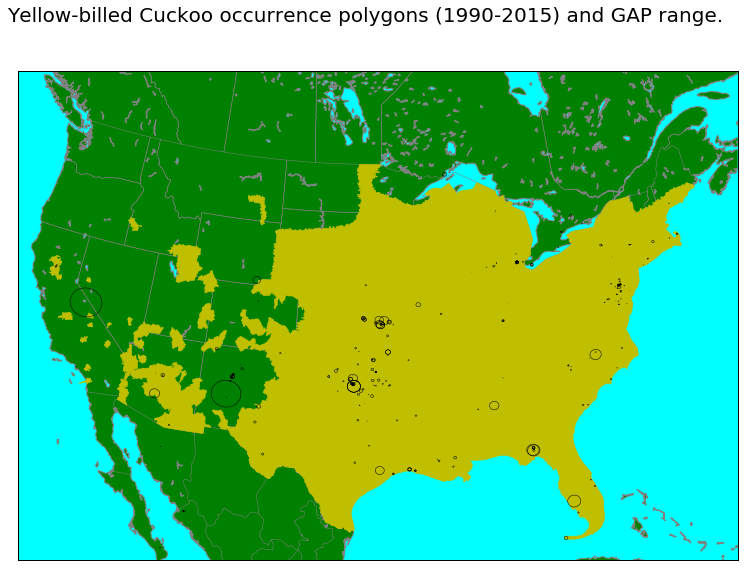

In [5]:
# Packages needed for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2,
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name),
        'drawbounds': True, 'linewidth': .5, 'linecolor': 'k',
        'fillcolor': None}

# Display occurrence polygons
map_these=[shp1, shp2]
title="Yellow-billed Cuckoo occurrence polygons ({0}) and GAP range.".format(years)

# Basemap
fig = plt.figure(figsize=(14,9))
ax = plt.subplot(1,1,1)
map = Basemap(projection='aea', resolution='i', lon_0=-95.5, lat_0=39.5,
              height=3400000, width=5000000)
map.drawcoastlines(color='grey')
map.drawstates(color='grey')
map.drawcountries(color='grey')
map.fillcontinents(color='green',lake_color='aqua')
map.drawmapboundary(fill_color='aqua')

for mapfile in map_these:
    # Add shapefiles to the map
    if mapfile['fillcolor'] == None:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'],
                          linewidth=mapfile['linewidth'],
                          color=mapfile['linecolor'])
    else:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'])
        # Code for extra formatting -- filling in polygons setting border
        # color
        patches = []
        for info, shape in zip(map.mapfile_info, map.mapfile):
            patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(patches,
                                          facecolor= mapfile['fillcolor'],
                                          edgecolor=mapfile['linecolor'],
                                          linewidths=mapfile['linewidth'],
                                          zorder=2))
fig.suptitle(title, fontsize=20)

# 4. Evaluate GAP Known Range Data
The first step in using occurrence records to evaluate GAP range is to build another database to hold the GAP 12 digit HUCs and range for the species, as well as for performing the necessary spatial queries.  The GAP range is retrieved from ScienceBase and the HUCs would be too if they were available as a shapefile.  

In [11]:
#%run 'make_range_evaluation_db.py'

Next, buffered occurrence point circles can be spatially compared against the HUC layer in order to determine which HUCs they can be attributed to.  After they attributed to HUCs, the results can be recorded in the species' range map table in terms of whether the two data sets agreed and whether they validate the GAP range data for any HUCs.  

For each evaluation, which is documented with a unique identifier in the database, a column is added for 1) how many records could be attributed to each huc and 2) whether the there is agreement at that huc (1 for yes, 0 for no, 'None' for no data for that huc).  A third column for whether the GAP range has been validated is assessed too, but that would not be specific to any one evaluation; it would assess all evaluation columns.

Evaluations are unique entities composed of filtered data and evaluation methods and parameters.  For this example, the method used was intersection with an error tolerance of 40% during the intersection.  That means that an occurrence was attributed to a HUC when > 60% of the occurrence circle occurred in the HUC.  The figure below illustrates how this plays out: circles are occurrence polygons, blue polygons are hucs, and numbers tell how many occurrences were attributed to the huc.  Note that that huc with 3 occurrences contains 3 small occurrence circles that are identical and therefore appear as one.  

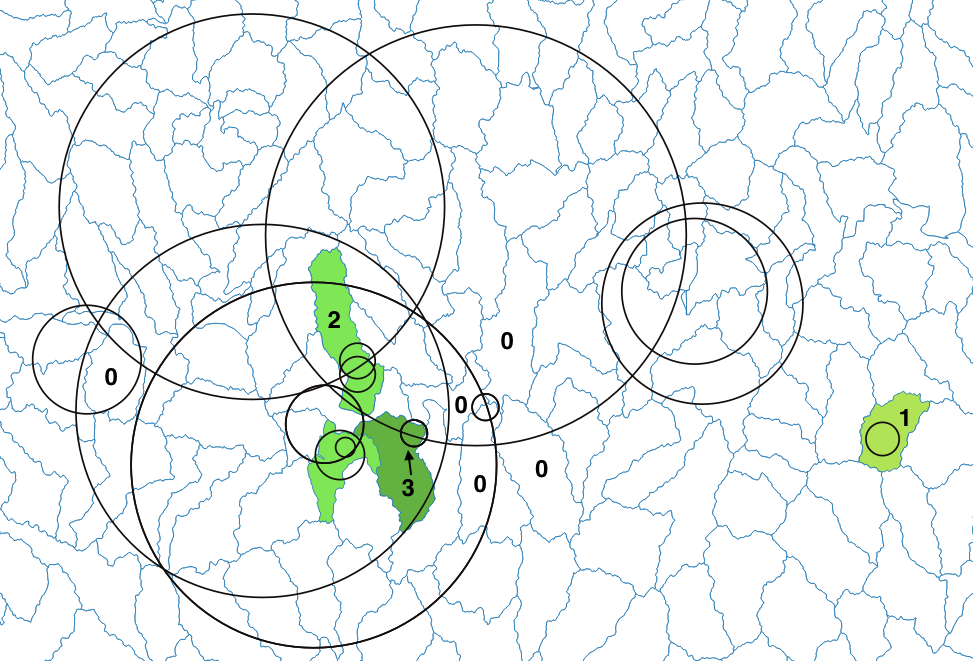

In [16]:
Image("/users/nmtarr/Documents/RANGES/Fig1.png")

In [ ]:
#%run 'eval_gbif1.py'

Text(0.5, 0.98, 'Yellow-billed Cuckoo eval_gbif1 (40% error, pad = 2 occurrences)')

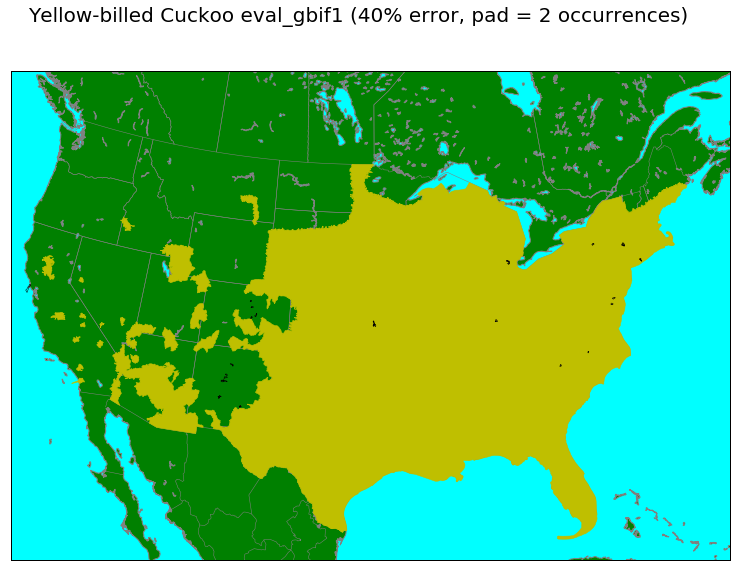

In [25]:
shp3 = {'file': '{0}{1}_eval_gbif1'.format(outDir, gap_id),
        'drawbounds': True, 'linewidth': .5, 'linecolor': 'k',
        'fillcolor': None}

# Display occurrence polygons
map_these=[shp1, shp3]
title="Yellow-billed Cuckoo eval_gbif1 (40% error, pad = 2 occurrences)"

# Basemap
fig = plt.figure(figsize=(14,9))
ax = plt.subplot(1,1,1)
map = Basemap(projection='aea', resolution='i', lon_0=-95.5, lat_0=39.5,
              height=3400000, width=5000000)
map.drawcoastlines(color='grey')
map.drawstates(color='grey')
map.drawcountries(color='grey')
map.fillcontinents(color='green',lake_color='aqua')
map.drawmapboundary(fill_color='aqua')

for mapfile in map_these:
    # Add shapefiles to the map
    if mapfile['fillcolor'] == None:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'],
                          linewidth=mapfile['linewidth'],
                          color=mapfile['linecolor'])
    else:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'])
        # Code for extra formatting -- filling in polygons setting border
        # color
        patches = []
        for info, shape in zip(map.mapfile_info, map.mapfile):
            patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(patches,
                                          facecolor= mapfile['fillcolor'],
                                          edgecolor=mapfile['linecolor'],
                                          linewidths=mapfile['linewidth'],
                                          zorder=2))
fig.suptitle(title, fontsize=20)

# BONUS Automated Range Delineation
I generated yearly, monthly, and seasonal ranges for the yellow-billed cuckoo with spatialite's concave hull function.  Each map was stored as a record in a table with geometry within range evaluation database (for now).  Below is an example of a summer range map.  It does not appear useful but maybe the delineation method could be improved or integrating more occurrence records will improve it.

In [ ]:
#%run 'make_range_polygons.py'

Text(0.5, 0.98, 'Yellow-billed Cuckoo GAP range, concave hull range and occurrences')

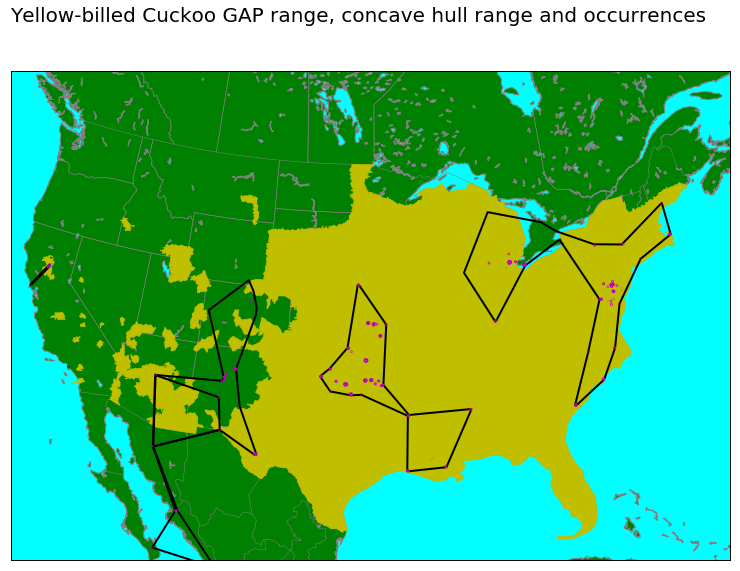

In [11]:
shp4 = {'file': '{0}summer_range'.format(outDir, gap_id),
        'drawbounds': True, 'linewidth': 2., 'linecolor': 'k',
        'fillcolor': None}

shp5 = {'file': '{0}summer_occs'.format(outDir, gap_id),
        'drawbounds': True, 'linewidth': 2., 'linecolor': 'm',
        'fillcolor': None}

# Display occurrence polygons
map_these=[shp1, shp4, shp5]
title="Yellow-billed Cuckoo GAP range, concave hull range and occurrences"

# Basemap
fig = plt.figure(figsize=(14,9))
ax = plt.subplot(1,1,1)
map = Basemap(projection='aea', resolution='i', lon_0=-95.5, lat_0=39.5,
              height=3400000, width=5000000)
map.drawcoastlines(color='grey')
map.drawstates(color='grey')
map.drawcountries(color='grey')
map.fillcontinents(color='green',lake_color='aqua')
map.drawmapboundary(fill_color='aqua')

for mapfile in map_these:
    # Add shapefiles to the map
    if mapfile['fillcolor'] == None:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'],
                          linewidth=mapfile['linewidth'],
                          color=mapfile['linecolor'])
    else:
        map.readshapefile(mapfile['file'], 'mapfile',
                          drawbounds=mapfile['drawbounds'])
        # Code for extra formatting -- filling in polygons setting border
        # color
        patches = []
        for info, shape in zip(map.mapfile_info, map.mapfile):
            patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(patches,
                                          facecolor= mapfile['fillcolor'],
                                          edgecolor=mapfile['linecolor'],
                                          linewidths=mapfile['linewidth'],
                                          zorder=2))
fig.suptitle(title, fontsize=20)